# MARBLE Training Example with Time-Aligned EEG Data

This notebook demonstrates how to use the functions in `data_processing.py` to train MARBLE models on EEG data with time-aligned labels.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import mne
import torch
import pickle

import MARBLE
from MARBLE import postprocessing, plotting

from data_processing import *

## Example 3: Load and process EEG data

Now let's load some EEG data from files and process it for MARBLE.

Found 690 available files to process
Processing batch 1
  Loading file: 2024_08_16_00_00_00_bipolar.fif
Setting reference time to: 2024-08-16 07:00:00


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_16_00_00_00_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 2
  Loading file: 2024_08_16_13_57_05_bipolar.fif
  Loading file: 2024_08_16_14_15_59_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_16_13_57_05_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_16_14_15_59_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 3
  Loading file: 2024_08_16_19_51_38_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_16_19_51_38_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 4
  Loading file: 2024_08_17_00_00_00_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_17_00_00_00_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 5
  Loading file: 2024_08_17_01_43_10_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_17_01_43_10_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 6
  Loading file: 2024_08_17_05_02_33_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_17_05_02_33_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 7
  Loading file: 2024_08_17_05_57_41_bipolar.fif
  Loading file: 2024_08_18_22_08_58_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_17_05_57_41_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_18_22_08_58_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 8
  Loading file: 2024_08_19_01_28_37_bipolar.fif
  Loading file: 2024_08_19_01_28_47_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_01_28_37_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_01_28_47_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 9
  Loading file: 2024_08_19_03_17_42_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_03_17_42_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 10
  Loading file: 2024_08_19_03_45_14_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_03_45_14_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 11
  Loading file: 2024_08_19_04_03_57_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_04_03_57_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 12
  Loading file: 2024_08_19_08_30_49_bipolar.fif
  Loading file: 2024_08_19_09_53_04_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_08_30_49_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_09_53_04_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 13
  Loading file: 2024_08_19_10_13_33_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_10_13_33_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 14
  Loading file: 2024_08_19_13_02_22_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_13_02_22_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 15
  Loading file: 2024_08_19_15_14_09_bipolar.fif
Processing batch 16
  Loading file: 2024_08_19_17_56_19_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_15_14_09_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_17_56_19_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 17
  Loading file: 2024_08_19_19_48_58_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_19_48_58_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 18
  Loading file: 2024_08_19_20_12_25_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_20_12_25_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 19
  Loading file: 2024_08_19_20_47_47_bipolar.fif
  Loading file: 2024_08_19_21_09_02_bipolar.fif
  Loading file: 2024_08_20_00_00_00_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_20_47_47_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_19_21_09_02_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_00_00_00_bipolar

Processing batch 20
  Loading file: 2024_08_20_00_47_06_bipolar.fif
  Loading file: 2024_08_20_01_41_01_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_00_47_06_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_01_41_01_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 21
  Loading file: 2024_08_20_05_01_13_bipolar.fif
Processing batch 22
  Loading file: 2024_08_20_07_29_51_bipolar.fif
  Loading file: 2024_08_20_07_30_58_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_05_01_13_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_07_29_51_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_07_30_58_bipolar

Processing batch 23
  Loading file: 2024_08_20_11_28_35_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_11_28_35_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 24
  Loading file: 2024_08_20_11_47_34_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_11_47_34_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 25
  Loading file: 2024_08_20_12_05_23_bipolar.fif
  Loading file: 2024_08_20_18_36_48_bipolar.fif
  Loading file: 2024_08_20_18_37_21_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_12_05_23_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_18_36_48_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_18_37_21_bipolar

Processing batch 26
  Loading file: 2024_08_20_21_15_19_bipolar.fif
  Loading file: 2024_08_20_21_20_15_bipolar.fif
  Loading file: 2024_08_21_00_00_00_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_21_15_19_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_20_21_20_15_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_00_00_00_bipolar

Processing batch 27
  Loading file: 2024_08_21_02_55_23_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_02_55_23_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 28
  Loading file: 2024_08_21_04_40_15_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_04_40_15_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 29
  Loading file: 2024_08_21_08_53_47_bipolar.fif
  Loading file: 2024_08_21_09_51_26_bipolar.fif
  Loading file: 2024_08_21_10_17_14_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_08_53_47_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_09_51_26_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_10_17_14_bipolar

Processing batch 30
  Loading file: 2024_08_21_10_59_47_bipolar.fif
Processing batch 31
  Loading file: 2024_08_21_11_22_35_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_10_59_47_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_11_22_35_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 32
  Loading file: 2024_08_21_12_46_41_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_12_46_41_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 33
  Loading file: 2024_08_21_13_34_11_bipolar.fif
  Loading file: 2024_08_21_13_39_08_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_13_34_11_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_13_39_08_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 34
  Loading file: 2024_08_21_17_57_51_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_17_57_51_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 35
  Loading file: 2024_08_21_20_31_31_bipolar.fif
Processing batch 36
  Loading file: 2024_08_21_20_57_03_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_20_31_31_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_20_57_03_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 37
  Loading file: 2024_08_21_21_16_13_bipolar.fif
  Loading file: 2024_08_21_21_22_20_bipolar.fif
  Loading file: 2024_08_21_21_39_30_bipolar.fif
Processing batch 38
  Loading file: 2024_08_21_21_42_19_bipolar.fif
  Loading file: 2024_08_22_02_55_12_bipolar.fif
  Loading file: 2024_08_22_03_33_21_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_21_16_13_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_21_22_20_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_21_21_39_30_bipolar

Processing batch 39
  Loading file: 2024_08_22_04_38_01_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_22_04_38_01_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 40
  Loading file: 2024_08_22_06_38_35_bipolar.fif
  Loading file: 2024_08_22_08_45_39_bipolar.fif
  Loading file: 2024_08_22_13_12_25_bipolar.fif
  Loading file: 2024_08_22_18_18_31_bipolar.fif
Processing batch 41
  Loading file: 2024_08_22_21_42_03_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_22_06_38_35_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_22_08_45_39_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_22_13_12_25_bipolar

Processing batch 42
  Loading file: 2024_08_22_22_26_28_bipolar.fif
  Loading file: 2024_08_23_00_44_05_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_22_22_26_28_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_00_44_05_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 43
  Loading file: 2024_08_23_02_51_54_bipolar.fif
  Loading file: 2024_08_23_05_41_14_bipolar.fif
Processing batch 44
  Loading file: 2024_08_23_08_48_47_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_02_51_54_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_05_41_14_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_08_48_47_bipolar

  Loading file: 2024_08_23_09_14_13_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_09_14_13_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 45
  Loading file: 2024_08_23_09_50_04_bipolar.fif
  Loading file: 2024_08_23_10_05_45_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_09_50_04_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_10_05_45_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 46
  Loading file: 2024_08_23_11_09_19_bipolar.fif
  Loading file: 2024_08_23_11_09_30_bipolar.fif
  Loading file: 2024_08_23_11_13_47_bipolar.fif
  Loading file: 2024_08_23_11_27_08_bipolar.fif
  Loading file: 2024_08_23_13_58_03_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_11_09_19_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_11_09_30_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_11_13_47_bipolar

Processing batch 47
  Loading file: 2024_08_23_18_27_13_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_18_27_13_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 48
  Loading file: 2024_08_23_19_41_53_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_19_41_53_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 49
  Loading file: 2024_08_23_20_15_29_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_20_15_29_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Processing batch 50
  Loading file: 2024_08_23_21_22_51_bipolar.fif
  Loading file: 2024_08_23_22_02_00_bipolar.fif


/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_21_22_51_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/home/honglab/leijiaxin/MARBLE/data_processing.py:301: RuntimeWarning: This filename (./preprocessed/bipolar/2024_08_23_22_02_00_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


Created time-based labels with shape: (50, 60000, 1)
Loaded 50 batches with shape: (50, 60000, 6)
Created labels with shape: (50, 60000, 1)
Saved preprocessed data to temp_Data/20240816_000000_20240823_220200_PreMARBLE_dataset.npz
Loaded data shape: (50, 60000, 6)
Time array shape: (50, 60000, 1)
Used 81 file(s)
Next file index: 81


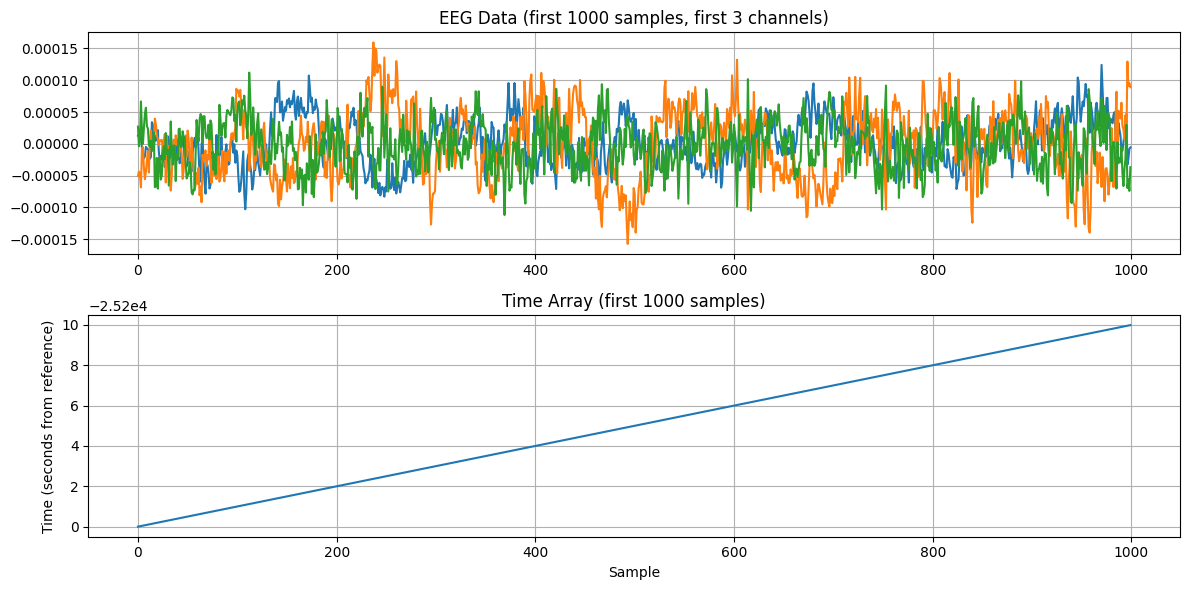

In [2]:
load_dataset = False  # Whether to load preprocessed dataset

# Define parameters
data_dir = "./preprocessed/bipolar"
max_samples = 10000  # Use a smaller number for demonstration
batch_size = 20  # Number of batches to create
max_files = None  # Maximum number of files to read
resample_freq = 50  # Resampling frequency in Hz
save_data = True  # Whether to save preprocessed data
save_dir = "temp_Data"  # Directory to save preprocessed data
label_type = "time"

if load_dataset:
    # Find available preprocessed datasets
    dataset_files = find_preprocessed_datasets(save_dir)
    if dataset_files:
        # Load the most recent dataset
        batch_data, batch_times = load_preprocessed_data(dataset_files[-1])
        print(f"Loaded preprocessed data from {dataset_files[-1]}")
        used_files = []  # No file tracking needed when loading preprocessed
        next_file_idx = 0
    else:
        print("No preprocessed datasets found, loading from raw files...")
        load_dataset = False

if not load_dataset:
    # Load data from raw files
    batch_data, batch_times, used_files, next_file_idx = load_merged_data(
        data_dir=data_dir,
        max_samples=max_samples,
        batch_size=batch_size,
        max_files=max_files,
        resample_freq=resample_freq,
        save_data=save_data,
        save_dir=save_dir,
        label_type=label_type,
    )

print(f"Loaded data shape: {batch_data.shape}")
print(f"Time array shape: {batch_times.shape}")
if not load_dataset:
    print(f"Used {len(used_files)} file(s)")
    print(f"Next file index: {next_file_idx}")

# Plot samples from first batch to check data quality
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(batch_data[0, :1000, :3])  # First batch, first 1000 samples, first 3 channels
plt.title('EEG Data (first 1000 samples, first 3 channels)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(batch_times[0, :1000])  # First batch, first 1000 time points
plt.title('Time Array (first 1000 samples)')
plt.xlabel('Sample')
plt.ylabel('Time (seconds from reference)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Example 4: Prepare data for MARBLE

In [3]:
# Prepare data for MARBLE
pos_list, x_list, labels = prepare_MARBLE_data(batch_data, batch_times)

Created 50 batches of data
Position shape: (59999, 6)
Vector shape: (59999, 6)
Labels shape: (59999, 1)


: 

## Example 5: Train a MARBLE model with time labels

In [ ]:
# Define flags for loading saved data/model
load_dataset = False 
load_model = False

# Define save paths
save_path = 'temp_Data/eeg_dataset.pkl'
model_path = 'temp_Data/eeg_model.pkl'

# Define MARBLE parameters
params = {
    "epochs": 100,  # Use fewer epochs for demonstration
    "order": 1,
    "hidden_channels": [256,128,64],
    "batch_size": 256,
    "lr": 1e-3,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "out_channels": 5,
    "inner_product_features": False,
    "diffusion": False,
    "batch_norm": True,
    "seed": 42,
}

# Construct or load dataset
k_value = 500
if not load_dataset:
    Dataset = MARBLE.construct_dataset(
        anchor=pos_list, 
        vector=x_list,
        label=labels,  # Use time-based labels
        graph_type="cknn",
        k=k_value,  
        Sampling=False,
        number_of_eigenvectors=500,
    )
    with open(save_path, 'wb') as f:
        pickle.dump(Dataset, f)
    print(f"Dataset saved to {save_path}")
else:
    with open(save_path, 'rb') as f:
        Dataset = pickle.load(f)
    print(f"Dataset loaded from {save_path}")

# Train or load model
model = MARBLE.net(Dataset, params=params)

if not load_model:
    model.fit(Dataset)
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_path}")
else:
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {model_path}")

# Transform data and visualize embeddings
transformed_data = model.transform(Dataset)
transformed_data = postprocessing.embed_in_2D(transformed_data)
transformed_data = MARBLE.distribution_distances(Dataset)


---- Ignored 7 out of 50 samples due to unconnected graphs with k=500

---- Embedding dimension: 6
---- Signal dimension: 6
---- Computing kernels ... 

<Figure size 400x400 with 0 Axes>

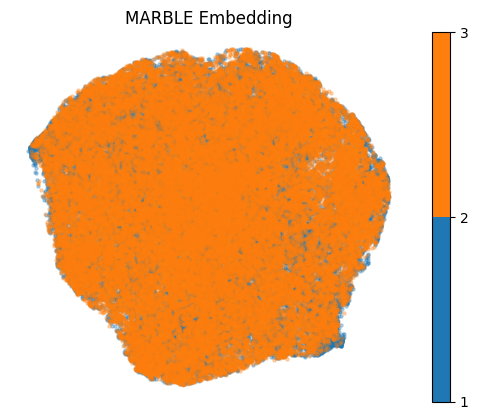


 No PCA embedding performed. Embedding seems to be               already in 2D.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!


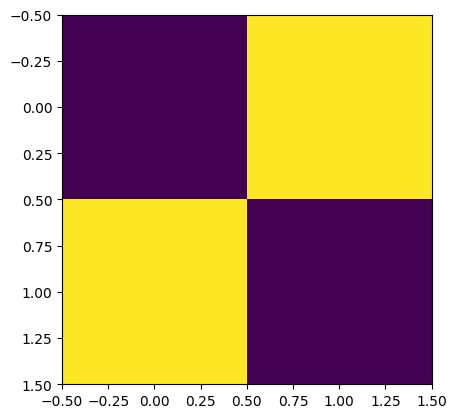

<Figure size 400x400 with 0 Axes>

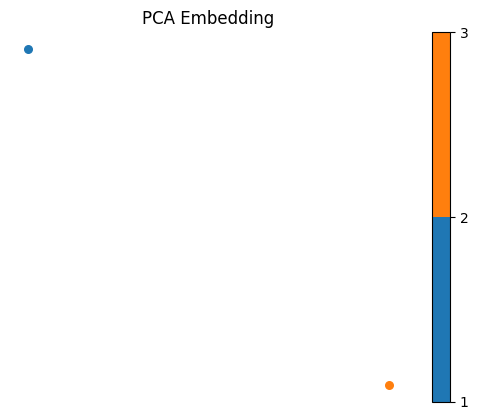


 No tsne embedding performed. Embedding seems to be               already in 2D.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!


<Figure size 400x400 with 0 Axes>

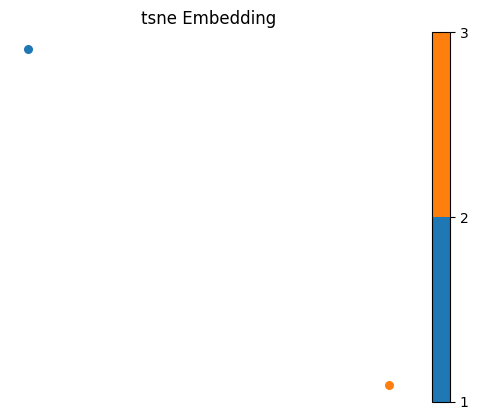


 No umap embedding performed. Embedding seems to be               already in 2D.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!


<Figure size 400x400 with 0 Axes>

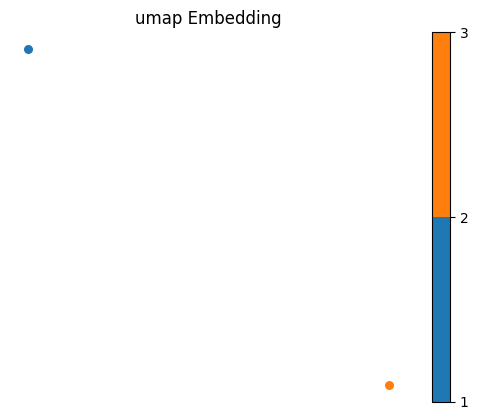


 No Isomap embedding performed. Embedding seems to be               already in 2D.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!


<Figure size 400x400 with 0 Axes>

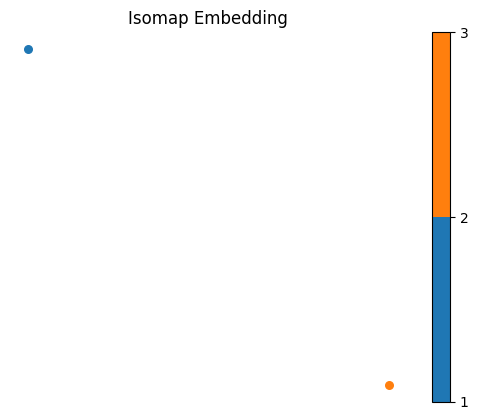


 No MDS embedding performed. Embedding seems to be               already in 2D.
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!


<Figure size 400x400 with 0 Axes>

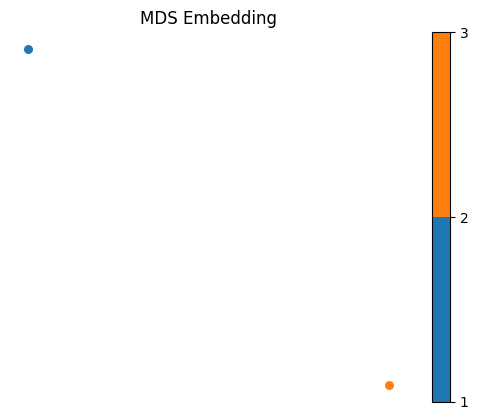

Results saved to temp_Figures/ directory.


In [ ]:
from MARBLE import geometry

# Visualize embeddings
plt.figure(figsize=(4, 4))
ax = plotting.embedding(transformed_data, transformed_data.y.numpy().astype(int))
plt.title('MARBLE Embedding')
plt.savefig('temp_Figures/eeg_marble_embedding.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.4, 4.8))
im = plt.imshow(transformed_data.dist)

# Plot different embeddings
embed_types = ['PCA', 'tsne', 'umap', 'Isomap', 'MDS']

for embed_typ in embed_types:
    emb, _ = geometry.embed(transformed_data.dist, embed_typ=embed_typ)
    plt.figure(figsize=(4, 4))
    ax = plotting.embedding(emb, np.array([0,1]), s=30, alpha=1)
    plt.title(f'{embed_typ} Embedding')
    plt.savefig(f'temp_Figures/eeg_{embed_typ.lower()}_embedding.png', dpi=300, bbox_inches='tight')
    plt.show()

print("=" * 40)
print("Results saved to temp_Figures/ directory.")